In [1]:
using UnboundedBNN, JLD2, Plots, Suppressor, PGFPlotsX, Statistics, Random
using UnboundedBNN: TransformedDistribution, get_μ, get_σ

In [25]:
push!(PGFPlotsX.CUSTOM_PREAMBLE, raw"\usepgfplotslibrary{fillbetween}");
push!(PGFPlotsX.CUSTOM_PREAMBLE, raw"\usepackage[dvipsnames]{xcolor}");

In [3]:
save_figures = false

false

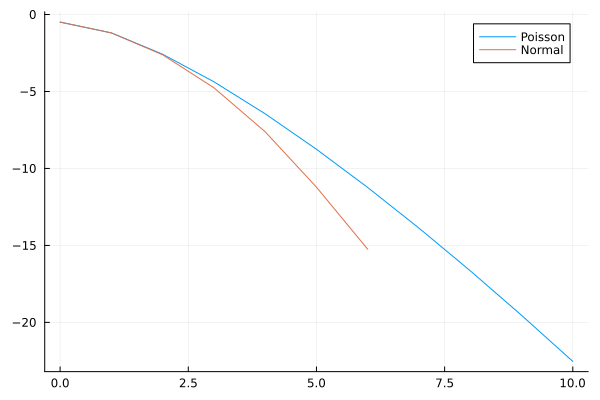

In [4]:
let 
    # prior_normal = discretize(H() * Normal(0.0f0 , 1.8f0))
    # prior_poisson = Poisson(1.0f0)
    prior_normal = discretize(H() * Normal(0.0f0 , 1.15f0))
    prior_poisson = Poisson(0.5f0)  

    plot(0:10, x -> log(pmf(prior_poisson, x)), label="Poisson", legend=:topright)
    plot!(0:10, x -> log(pmf(prior_normal, x)), label="Normal")
end

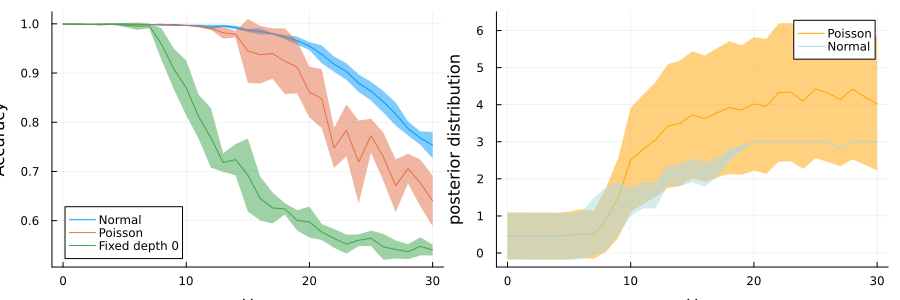

In [5]:
begin 
    ω_range = 0:30
    depth_range = 0:0
    dim = 32
    runs = 5
    folder_normal = "data/spiral/normal_predict"
    folder_poisson = "data/spiral/poisson_predict"

    mean_normal = zeros(length(ω_range), runs)
    std_normal = zeros(length(ω_range), runs)
    mean_poisson = zeros(length(ω_range), runs)
    std_poisson = zeros(length(ω_range), runs)

    acc_normal = zeros(length(ω_range), runs)
    acc_poisson = zeros(length(ω_range), runs)
    acc_fixed = zeros(length(depth_range), length(ω_range), runs)

    for (idepth, depth) in enumerate(depth_range)
        for (iω, ω) in enumerate(ω_range)
            for run in 1:runs
                acc_fixed[idepth, iω, run] = load("data/spiral/fixed/depth_$(depth)/run_$(run)/dim_$(dim)/dim_$(dim)_omega_$ω.jld2")["results/accuracy_test"]
            end
        end
    end

    for (ind, ω) in enumerate(ω_range)
        @suppress begin
            for run in 1:runs
                mean_normal[ind,run] += mean(load(folder_normal * "/run_$(run)/dim_$(dim)/dim_$(dim)_omega_$ω.jld2")["results/posterior"])
                std_normal[ind,run] += std(load(folder_normal * "/run_$(run)/dim_$(dim)/dim_$(dim)_omega_$ω.jld2")["results/posterior"])
                mean_poisson[ind,run] += mean(load(folder_poisson * "/run_$(run)/dim_$(dim)/dim_$(dim)_omega_$ω.jld2")["results/posterior"])
                std_poisson[ind,run] += std(load(folder_poisson * "/run_$(run)/dim_$(dim)/dim_$(dim)_omega_$ω.jld2")["results/posterior"])
                
                acc_normal[ind,run] += load(folder_normal * "/run_$(run)/dim_$(dim)/dim_$(dim)_omega_$ω.jld2")["results/accuracy_test"]
                acc_poisson[ind,run] += load(folder_poisson * "/run_$(run)/dim_$(dim)/dim_$(dim)_omega_$ω.jld2")["results/accuracy_test"]
            end
        end
    end

    p1 = plot(ω_range, mean(acc_normal; dims=2), ribbon=std(acc_normal; dims=2), label="Normal", xlabel="ω", ylabel="Accuracy")
    plot!(p1, ω_range, mean(acc_poisson; dims=2), ribbon=std(acc_poisson; dims=2), label="Poisson", xlabel="ω", ylabel="Accuracy")
    for (idepth, depth) in enumerate(depth_range)
        plot!(p1, ω_range, mean(acc_fixed[idepth, :, :]; dims=2), ribbon=std(acc_fixed[idepth, :, :]; dims=2), label="Fixed depth $(depth)", xlabel="ω", ylabel="Accuracy")
    end
    p2 = plot(ω_range, mean(mean_poisson; dims=2), ribbon = mean(std_poisson; dims=2), label="Poisson", xlabel="ω", color="orange", ylabel="posterior distribution")
    plot!(p2, ω_range, mean(mean_normal; dims=2), ribbon = mean(std_normal; dims=2), label="Normal", xlabel="ω", color="lightblue", ylabel="posterior distribution")
    plot(p1, p2, layout=(1,2), size=(900, 300))
end

# Accuracy comparison

In [6]:
ω_range = 0:30
depth_range = 0:0
dim = 32
runs = 5
folder_normal = "data/spiral/normal_predict"
folder_poisson = "data/spiral/poisson_predict"
folder_fixed = "data/spiral/fixed"

acc_normal = zeros(length(ω_range), runs)
acc_poisson = zeros(length(ω_range), runs)
acc_fixed = zeros(length(depth_range), length(ω_range), runs)

for (idepth, depth) in enumerate(depth_range)
    for (iω, ω) in enumerate(ω_range)
        for run in 1:runs
            acc_fixed[idepth, iω, run] = load(folder_fixed * "/depth_$(depth)/run_$(run)/dim_$(dim)/dim_$(dim)_omega_$ω.jld2")["results/accuracy_test"]
        end
    end
end

for (ind, ω) in enumerate(ω_range)
    @suppress begin
        for run in 1:runs
            mean_normal[ind,run] += mean(load(folder_normal * "/run_$(run)/dim_$(dim)/dim_$(dim)_omega_$ω.jld2")["results/posterior"])
            std_normal[ind,run] += std(load(folder_normal * "/run_$(run)/dim_$(dim)/dim_$(dim)_omega_$ω.jld2")["results/posterior"])
            mean_poisson[ind,run] += mean(load(folder_poisson * "/run_$(run)/dim_$(dim)/dim_$(dim)_omega_$ω.jld2")["results/posterior"])
            std_poisson[ind,run] += std(load(folder_poisson * "/run_$(run)/dim_$(dim)/dim_$(dim)_omega_$ω.jld2")["results/posterior"])
            
            acc_normal[ind,run] += load(folder_normal * "/run_$(run)/dim_$(dim)/dim_$(dim)_omega_$ω.jld2")["results/accuracy_test"]
            acc_poisson[ind,run] += load(folder_poisson * "/run_$(run)/dim_$(dim)/dim_$(dim)_omega_$ω.jld2")["results/accuracy_test"]
        end
    end
end

In [7]:
p_accuracy = @pgf Axis(
    {
        xlabel = "\$\\omega\$",
        ylabel = "test accuracy [\\%]",
        xmin = 0,
        xmax = 30,
        ymin = 50,
        ymax = 100,
        grid = "major",
        width = "4in",
        height = "2.6in",
        legend_pos = "south west",
    }
)

colors = ("RoyalBlue", "orange", "Emerald")

# normal (ours)
@pgf begin
    p_tmp = Plot(
        {
            "name path=normal-max",
            draw="none",
            forget_plot
        },
        Table(ω_range, 100 * mean(acc_normal[:,:]; dims=2)[:] + 100 * std(acc_normal[:,:]; dims=2)[:])
    )
    push!(p_accuracy, p_tmp)
    p_tmp = Plot(
        {
            "name path=normal-min",
            draw="none",
            forget_plot
        },
        Table(ω_range, 100 * mean(acc_normal[:,:]; dims=2)[:] - 100 * std(acc_normal[:,:]; dims=2)[:])
    )
    push!(p_accuracy, p_tmp)
    p_tmp = Plot(
        { 
            color = colors[1],
            fill = colors[1],
            opacity = 0.5,
            forget_plot,

        }, 
        raw"fill between [of=normal-max and normal-min]"
    )
    push!(p_accuracy, p_tmp)
    p_tmp = Plot({
            thick,
            color=colors[1],
            
        },
        Table(ω_range, 100 * mean(acc_normal[:,:]; dims=2)[:])
    )
    push!(p_accuracy, p_tmp)
    p_tmp = LegendEntry("normal prior (ours)")
    push!(p_accuracy, p_tmp)
end

# poisson 
@pgf begin
    p_tmp = Plot(
        {
            "name path=poisson-max",
            draw="none",
            forget_plot
        },
        Table(ω_range, 100 * mean(acc_poisson[:,:]; dims=2)[:] + 100 * std(acc_poisson[:,:]; dims=2)[:])
    )
    push!(p_accuracy, p_tmp)
    p_tmp = Plot(
        {
            "name path=poisson-min",
            draw="none",
            forget_plot
        },
        Table(ω_range, 100 * mean(acc_poisson[:,:]; dims=2)[:] - 100 * std(acc_poisson[:,:]; dims=2)[:])
    )
    push!(p_accuracy, p_tmp)
    p_tmp = Plot(
        { 
            color = colors[2],
            fill = colors[2],
            opacity = 0.5,
            forget_plot,
        }, 
        raw"fill between [of=poisson-max and poisson-min]"
    )
    push!(p_accuracy, p_tmp)
    p_tmp = Plot({
            thick,
            color=colors[2],
        },
        Table(ω_range, 100 * mean(acc_poisson[:,:]; dims=2)[:])
    )
    push!(p_accuracy, p_tmp)
    p_tmp = LegendEntry("Poisson prior \\cite{nazaret_variational_2022}")
    push!(p_accuracy, p_tmp)
end

# # fixed depths
# @pgf for (ind, depth) in enumerate(depth_range)
#     p_tmp = Plot(
#         {
#             "name path"="depth$(depth)-max",
#             draw="none",
#             forget_plot
#         },
#         Table(ω_range, 100 * mean(acc_fixed[ind,:,:]; dims=2)[:] + 100 * std(acc_fixed[ind,:,:]; dims=2)[:])
#     )
#     push!(p_accuracy, p_tmp)
#     p_tmp = Plot(
#         {
#             "name path"="depth$(depth)-min",
#             draw="none",
#             forget_plot
#         },
#         Table(ω_range, 100 * mean(acc_fixed[ind,:,:]; dims=2)[:] - 100 * std(acc_fixed[ind,:,:]; dims=2)[:])
#     )
#     push!(p_accuracy, p_tmp)
#     p_tmp = Plot(
#         { 
#             color = "orange",
#             fill = "orange",
#             opacity = 0.5,
#             forget_plot,
#         }, 
#         "fill between [of=depth$(depth)-max and depth$(depth)-min]"
#     )
#     push!(p_accuracy, p_tmp)
#     p_tmp = Plot({
#             thick,
#             color="orange",
#             dashed
#         },
#         Table(ω_range, 100 * mean(acc_fixed[ind,:,:]; dims=2)[:])
#     )
#     push!(p_accuracy, p_tmp)
# end
p_accuracy

In [8]:
save_figures ? pgfsave("exports/spiral_accuracy.pdf", p_accuracy; dpi = 300) : nothing
save_figures ? pgfsave("exports/spiral_accuracy.tikz", p_accuracy; dpi = 300) : nothing

# Posterior distributions

In [9]:
ω_range = 0:30
depth_range = 0:0
dim = 32
run = 1
folder_normal = "data/spiral/normal_predict"
folder_poisson = "data/spiral/poisson_predict"

post_normal = []
post_poisson = []

for (ind, ω) in enumerate(ω_range)
    @suppress begin
        push!(post_normal, load(folder_normal * "/run_$(run)/dim_$(dim)/dim_$(dim)_omega_$ω.jld2")["results/posterior"])
        push!(post_poisson, load(folder_poisson * "/run_$(run)/dim_$(dim)/dim_$(dim)_omega_$ω.jld2")["results/posterior"])
    end
end

In [10]:
p_posterior = @pgf Axis(
    {
        xlabel = "\$\\omega\$",
        ylabel = "network depth",
        xmin = 0,
        xmax = 30,
        ymin = 0,
        ymax = 8,
        grid = "major",
        width = "4in",
        height = "2.6in",
        legend_pos = "north west"
    }
)

colors = ("RoyalBlue", "orange", "Emerald")

# normal (ours)
@pgf begin
    p_tmp = Plot(
        {
            "name path=normal-max",
            draw="none",
            forget_plot
        },
        Table(ω_range, mean.(post_normal) + std.(post_normal))
    )
    push!(p_posterior, p_tmp)
    p_tmp = Plot(
        {
            "name path=normal-min",
            draw="none",
            forget_plot
        },
        Table(ω_range, mean.(post_normal) - std.(post_normal))
    )
    push!(p_posterior, p_tmp)
    p_tmp = Plot(
        { 
            color = colors[1],
            fill = colors[1],
            opacity = 0.5,
            forget_plot,

        }, 
        raw"fill between [of=normal-max and normal-min]"
    )
    push!(p_posterior, p_tmp)
    p_tmp = Plot({
            thick,
            color=colors[1],
        },
        Table(ω_range, mean.(post_normal))
    )
    push!(p_posterior, p_tmp)
    p_tmp = LegendEntry("normal prior (ours)")
    push!(p_posterior, p_tmp)
end

# poisson 
@pgf begin
    p_tmp = Plot(
        {
            "name path=poisson-max",
            draw="none",
            forget_plot
        },
        Table(ω_range, mean.(post_poisson) + std.(post_poisson))
    )
    push!(p_posterior, p_tmp)
    p_tmp = Plot(
        {
            "name path=poisson-min",
            draw="none",
            forget_plot
        },
        Table(ω_range, mean.(post_poisson) - std.(post_poisson))
    )
    push!(p_posterior, p_tmp)
    p_tmp = Plot(
        { 
            color = colors[2],
            fill = colors[2],
            opacity = 0.5,
            forget_plot,
        }, 
        raw"fill between [of=poisson-max and poisson-min]"
    )
    push!(p_posterior, p_tmp)
    p_tmp = Plot({
            thick,
            color=colors[2],
        },
        Table(ω_range, mean.(post_poisson))
    )
    push!(p_posterior, p_tmp)
    p_tmp = LegendEntry("Poisson prior \\cite{nazaret_variational_2022}")
    push!(p_posterior, p_tmp)
end

In [11]:
pgfsave("exports/spiral_posteriors.pdf", p_posterior; dpi = 300)

In [12]:
save_figures ? pgfsave("exports/spiral_posteriors.pdf", p_posterior; dpi = 300) : nothing
save_figures ? pgfsave("exports/spiral_posteriors.tikz", p_posterior; dpi = 300) : nothing

# Dataset plots

In [13]:
ω_plot = (0, 2, 5, 10, 20)

x_plot = []
y_plot = []
for ω in ω_plot
    x, y = generate_spiral(500, ω)
    push!(x_plot, x)
    push!(y_plot, y)
end

In [14]:
p_data = @pgf GroupPlot(
    {
        group_style =
        {
            group_size="5 by 1",
            xticklabels_at="edge bottom",
            yticklabels_at="edge left",
            horizontal_sep = "0.5cm",
        },
        ytick = "{-1,...,1}",
        ytick_style={draw="none"},
        xtick = "{-1,...,1}",
        xtick_style={draw="none"},
        width = "1.8in",
        height = "1.8in",
        xmin = -1.1,
        xmax = 1.1,
        ymin = -1.1,
        ymax = 1.1,
        axis_equal,
        grid = "none"
    },
    {title = "\$\\omega = $(ω_plot[1])\$"},
    Plot(
        {
            scatter, 
            only_marks, 
            opacity = 0.2,
            scatter_src = "explicit"
        }, 
        Table(
            {
                meta = "label"
            },
            x = x_plot[1][1,:], 
            y = x_plot[1][2,:], 
            label = y_plot[1]
        )
    ),
    {title = "\$\\omega = $(ω_plot[2])\$"},
    Plot(
        {
            scatter, 
            only_marks, 
            opacity = 0.2,
            scatter_src = "explicit"
        }, 
        Table(
            {
                meta = "label"
            },
            x = x_plot[2][1,:], 
            y = x_plot[2][2,:], 
            label = y_plot[2]
        )
    ),
    {title = "\$\\omega = $(ω_plot[3])\$"},
    Plot(
        {
            scatter, 
            only_marks, 
            opacity = 0.2,
            scatter_src = "explicit"
        }, 
        Table(
            {
                meta = "label"
            },
            x = x_plot[3][1,:], 
            y = x_plot[3][2,:], 
            label = y_plot[3]
        )
    ),
    {title = "\$\\omega = $(ω_plot[4])\$"},
    Plot(
        {
            scatter, 
            only_marks, 
            opacity = 0.2,
            scatter_src = "explicit"
        }, 
        Table(
            {
                meta = "label"
            },
            x = x_plot[4][1,:], 
            y = x_plot[4][2,:], 
            label = y_plot[4]
        )
    ),
    {title = "\$\\omega = $(ω_plot[5])\$"},
    Plot(
        {
            scatter, 
            only_marks, 
            opacity = 0.2,
            scatter_src = "explicit"
        }, 
        Table(
            {
                meta = "label"
            },
            x = x_plot[5][1,:], 
            y = x_plot[5][2,:], 
            label = y_plot[5]
        )
    ),
)

In [15]:
save_figures ? pgfsave("exports/spiral_data.pdf", p_data; dpi = 300) : nothing

# Priors and initialization

In [31]:
prior_poisson = Poisson(0.5)
init_poisson = Poisson(1.0)
prior_normal = discretize(H() * Normal(0.0f0 , 1.15f0))
init_normal = discretize(H() * Normal(0.0f0 , 1.8f0))

DiscreteDistribution{TruncatedDistribution{Normal{Float32}, Float64, Float64}}(TruncatedDistribution{Normal{Float32}, Float64, Float64}(Normal{Float32}(0.0f0, 1.8f0), 0.0, Inf))

In [48]:
p_prior = @pgf Axis(
    {
        xlabel = "\$L\$",
        ylabel = "\$\\ln p(L)\$",
        xmin = 0,
        xmax = 7,
        ymin = -20,
        ymax = 0,
        grid = "major",
        width = "4in",
        height = "2.6in",
        legend_pos = "south west",
        legend_cell_align="left",
    },
    Plot(
        {
            color = "RoyalBlue",
            thick,
            mark = "otimes"
        },
        Table(0:10, map(x -> UnboundedBNN.logpmf(prior_normal, x), 0:10))
    ),
    LegendEntry("Normal prior (ours)"),
    Plot(
        {
            color = "orange",
            thick,
            mark = "oplus"
        },
        Table(0:10, map(x -> UnboundedBNN.logpmf(prior_poisson, x), 0:10))
    ),
    LegendEntry("Poisson prior \\cite{nazaret_variational_2022}")
)

In [49]:
p_init = @pgf Axis(
    {
        xlabel = "\$L\$",
        ylabel = "\$\\ln q(L)\$",
        xmin = 0,
        xmax = 7,
        ymin = -10,
        ymax = 0,
        grid = "major",
        width = "4in",
        height = "2.6in",
        legend_pos = "south west",
        legend_cell_align="left",
    },
    Plot(
        {
            color = "RoyalBlue",
            thick,
            mark = "otimes"
        },
        Table(0:10, map(x -> UnboundedBNN.logpmf(init_normal, x), 0:10))
    ),
    LegendEntry("Normal prior (ours)"),
    Plot(
        {
            color = "orange",
            thick,
            mark = "oplus"
        },
        Table(0:10, map(x -> UnboundedBNN.logpmf(init_poisson, x), 0:10))
    ),
    LegendEntry("Poisson prior \\cite{nazaret_variational_2022}")
)

In [50]:
save_figures  = true

true

In [51]:
save_figures ? pgfsave("exports/spiral_prior.pdf", p_prior; dpi = 300) : nothing
save_figures ? pgfsave("exports/spiral_prior.tikz", p_prior; dpi = 300) : nothing
save_figures ? pgfsave("exports/spiral_init.pdf", p_init; dpi = 300) : nothing
save_figures ? pgfsave("exports/spiral_init.tikz", p_init; dpi = 300) : nothing